In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

##  Pneumonia Pridiction using Convolution Neural Networks

## Author Details:
- Name: Anmol Gupta
- Email: getanmol.gupta@gmail.com
- LinkedIn: www.linkedin.com/in/anmol-gupta-9a905a228

## Prepared For Practice Purpose please hit the upvote if you like the work

## What is Pneumonia?
**Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.Symptoms typically include some combination of productive or dry cough, chest pain, fever and difficulty breathing. The severity of the condition is variable. Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications or conditions such as autoimmune diseases.Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system. Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.**


![Pneumonia Image](https://continentalhospitals.com/uploads/mceu_31923284811699687086478.jpg)


## Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  Importing Required Libraries </div> 

In [3]:
pip install keras-tuner


Note: you may need to restart the kernel to use updated packages.
     -------------------------------------- 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [4]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from skimage import exposure
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras_tuner
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Activation,Dropout,BatchNormalization,InputLayer
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

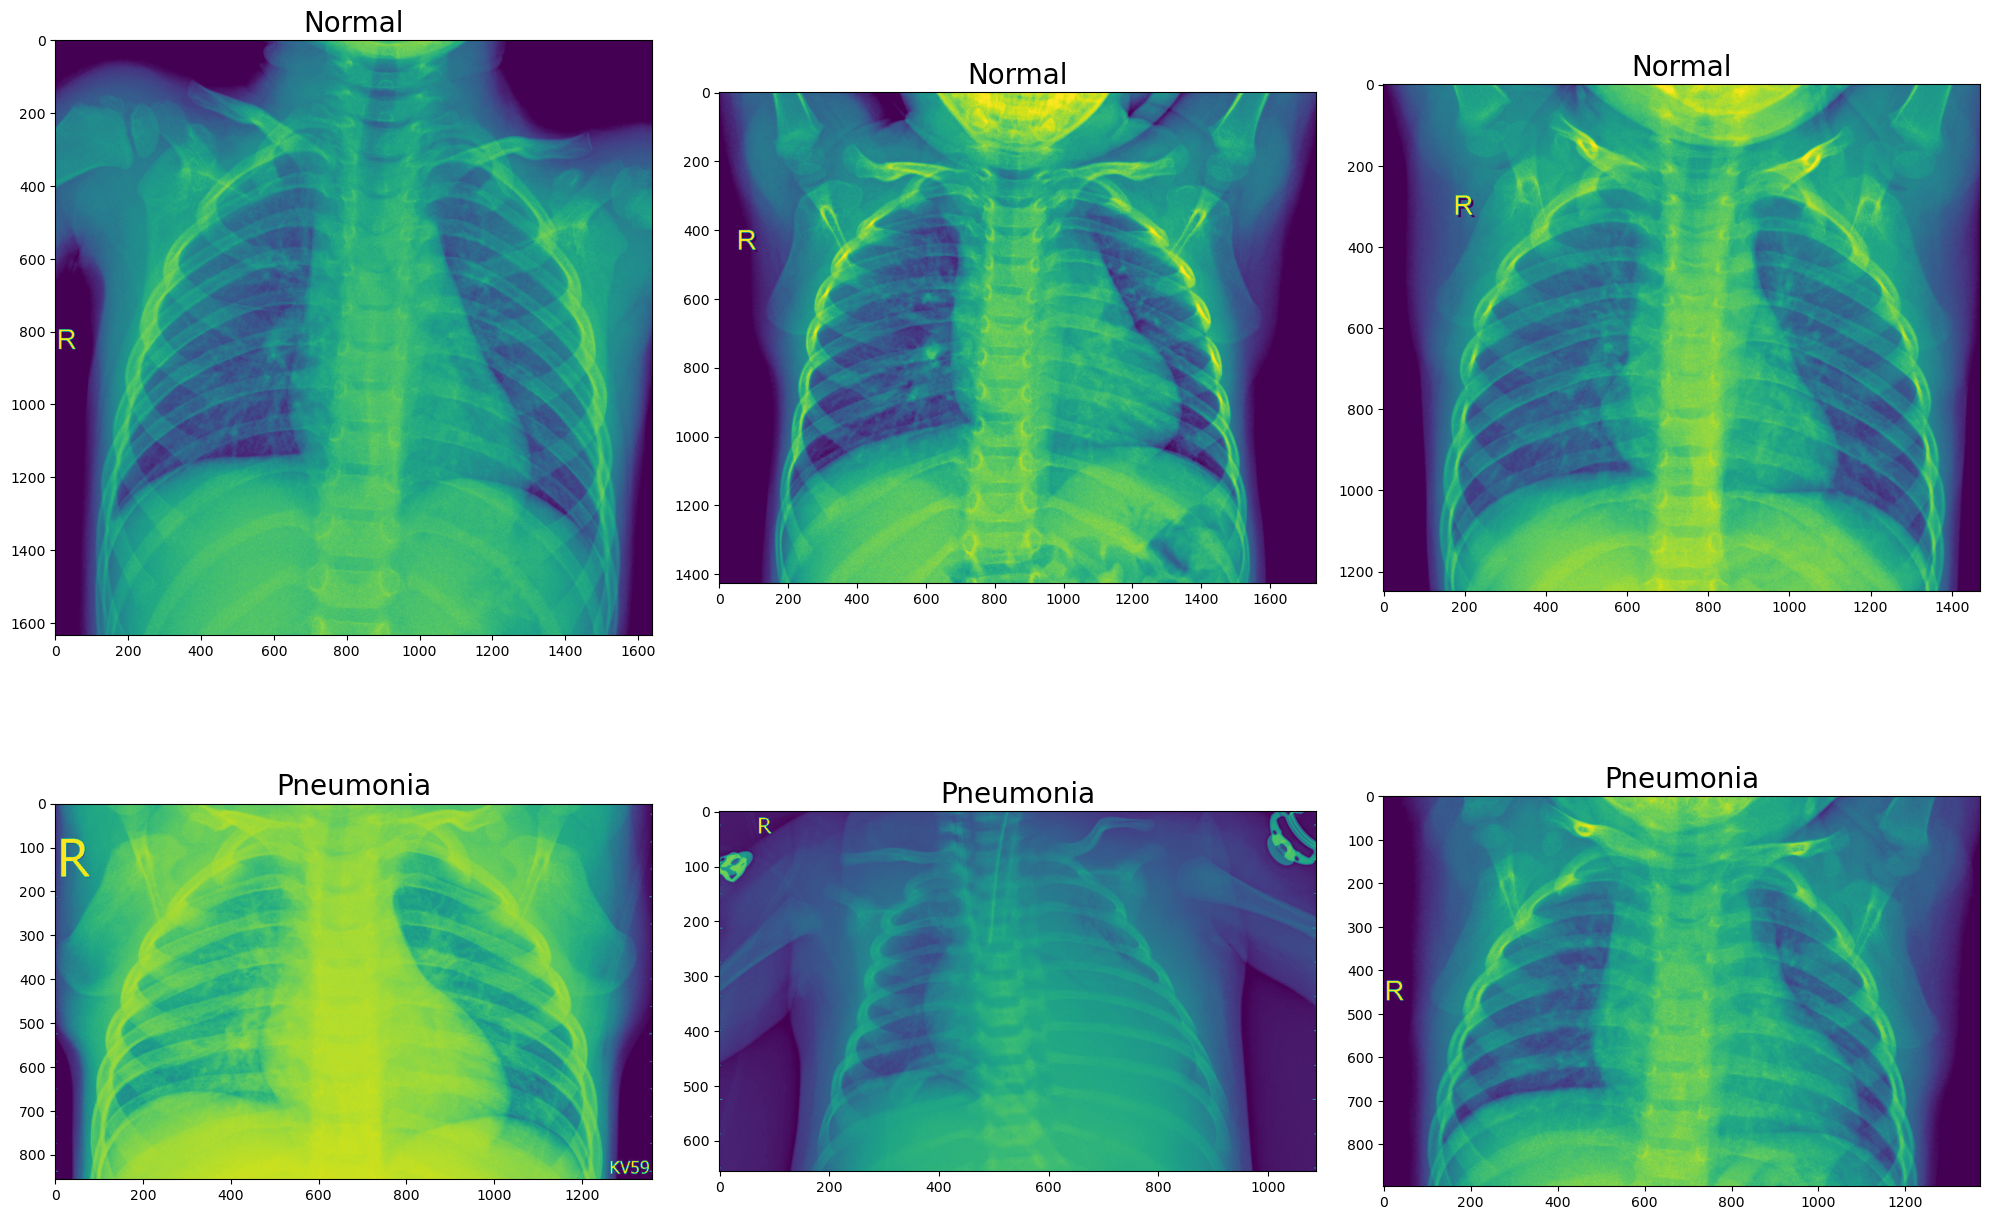

In [8]:
Normal_path = "C:\\Users\\aiman\\OneDrive\\Desktop\\projects\\Chest x ray\\data\\chest_xray\\chest_xray\\train\\NORMAL"
Pneumonia_path = "C:\\Users\\aiman\\OneDrive\\Desktop\\projects\\Chest x ray\\data\\chest_xray\\chest_xray\\train\\PNEUMONIA"


image_files = [os.path.join(Normal_path, filename) for filename in os.listdir(Normal_path)]
image_files2 = [os.path.join(Pneumonia_path, filename) for filename in os.listdir(Pneumonia_path)]


num_samples = 3

selected_images = random.sample(image_files, num_samples)
selected_images2 = random.sample(image_files2, num_samples)

#create subplots for displaying images
fig, axes = plt.subplots(2, num_samples, figsize=(20,14))

# Display each selected image from the first directory
for i, image_path in enumerate(selected_images):
    ax = axes[0, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Normal', fontsize=20)  # Increase font size for the title
    ax.axis('on')  # Show axis

# Display each selected image from the second directory
for i, image_path in enumerate(selected_images2):
    ax = axes[1, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Pneumonia', fontsize=20)  # Increase font size for the title
    ax.axis('on')  # Show axis
    


# Show the images 
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  EDA  </div> 

In [10]:
import os

# Path to the training directory
train_dir = "C:\\Users\\aiman\\OneDrive\\Desktop\\projects\\Chest x ray\\data\\chest_xray\\chest_xray\\train"

# Initialize counters for each class
normal_count = 0
pneumonia_count = 0

# Loop through each class directory and count the number of samples
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        if class_name.lower() == "normal":
            normal_count += len(os.listdir(class_path))
        elif class_name.lower() == "pneumonia":
            pneumonia_count += len(os.listdir(class_path))

# Print the counts for each class
print("Number of samples in Normal class:", normal_count)
print("Number of samples in Pneumonia class:", pneumonia_count)

# Calculate the imbalance ratio
imbalance_ratio = normal_count / pneumonia_count
print("Imbalance Ratio (Normal:Pneumonia):", imbalance_ratio)


Number of samples in Normal class: 1342
Number of samples in Pneumonia class: 3876
Imbalance Ratio (Normal:Pneumonia): 0.3462332301341589


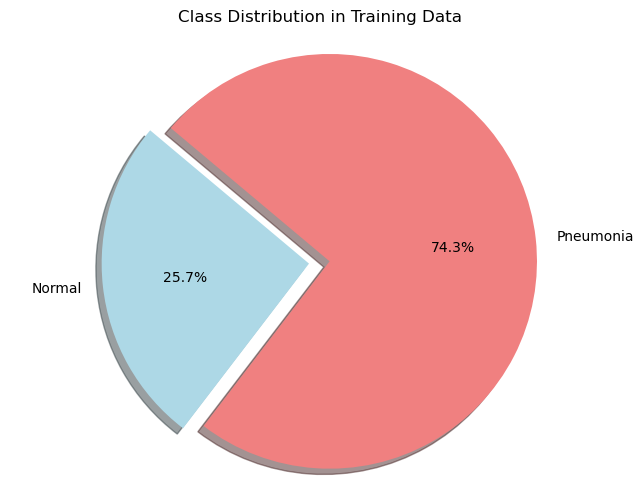

In [11]:
import os
import matplotlib.pyplot as plt

# Path to the training directory
train_dir = "C:\\Users\\aiman\\OneDrive\\Desktop\\projects\\Chest x ray\\data\\chest_xray\\chest_xray\\train"

# Initialize counters for each class
normal_count = 0
pneumonia_count = 0

# Loop through each class directory and count the number of samples
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        if class_name.lower() == "normal":
            normal_count += len(os.listdir(class_path))
        elif class_name.lower() == "pneumonia":
            pneumonia_count += len(os.listdir(class_path))

# Create labels and counts for the pie chart
labels = ['Normal', 'Pneumonia']
sizes = [normal_count, pneumonia_count]
colors = ['lightblue', 'lightcoral']
explode = (0, 0.1)  # explode the 2nd slice (i.e., 'Pneumonia')

# Plotting the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Class Distribution in Training Data')
plt.show()


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  Preprocessing  </div> 

#### Preprocessing training data

In [12]:
batch_size = 8

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    directory="C:\\Users\\aiman\\OneDrive\\Desktop\\projects\\Chest x ray\\data\\chest_xray\\chest_xray\\train",
    target_size=(600, 600),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'  # or 'categorical' if multiple classes
)

# this is a similar generator, for validation data
validation_generator = val_datagen.flow_from_directory(
        "C:\\Users\\aiman\\OneDrive\\Desktop\\projects\\Chest x ray\\data\\chest_xray\\chest_xray\\val",
        target_size=(600, 600),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='binary'  # or 'categorical' if multiple classes
        )

test_generator = test_datagen.flow_from_directory(
        "C:\\Users\\aiman\\OneDrive\\Desktop\\projects\\Chest x ray\\data\\chest_xray\\chest_xray\\test",
        target_size=(600, 600),
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='binary'  # or 'categorical' if multiple classes
        )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  Creating CNN model  </div> 

In [13]:
# create baseline CNN model

model = Sequential()

model.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',input_shape=(600,600,1),kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

model.add(Conv2D(164,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

model.add(Flatten())

model.add(Dense(164,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())

model.add(Dense(1,activation='sigmoid'))

In [14]:
from tensorflow.keras.optimizers import Adadelta
optimizer = Adadelta(learning_rate=1.0, rho=0.95)

model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

CALLBACKS = [early_stopping_cb]

In [ ]:
history = model.fit(
    train_generator,
    callbacks=CALLBACKS,
    epochs=5,
    validation_data=test_generator
)

Epoch 1/5
 20/652 [..............................] - ETA: 8:51:46 - loss: 2.7213 - accuracy: 0.5688

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 600, 600, 256)  │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 600, 600, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 300, 300, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 300, 300, 164)  │       378,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300, 300, 164)  │           656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 150, 150, 164)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 150, 150, 64)   │        94,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 92416)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 164)            │    15,156,388 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 164)            │           656 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 164)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        21,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 47,107,229 (179.70 MB)

 Trainable params: 15,701,785 (59.90 MB)

 Non-trainable params: 1,872 (7.31 KB)

 Optimizer params: 31,403,572 (119.80 MB)

In [12]:
Evaluation = model.evaluate(validation_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8750 - loss: 0.7107


In [13]:
Evaluation

[0.7287038564682007, 0.8125]

In [14]:
print("Accuracy of this model is :" ,Evaluation[1]*100,"%")

Accuracy of this model is : 81.25 %


## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  Accuracy and Loss Graph  </div> 

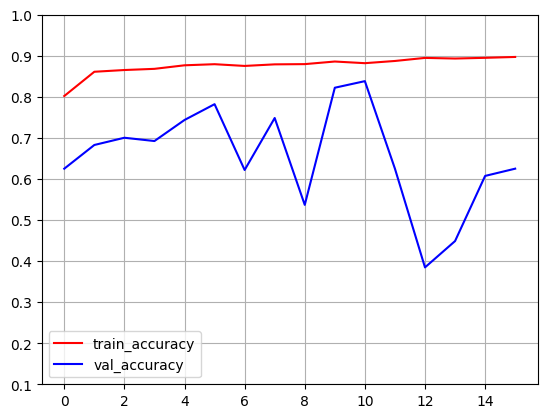

In [15]:
plt.plot(history.history['accuracy'], color='red', label='train_accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
plt.legend()
plt.grid()

# Set y-axis limits from 0.1 to 10
plt.ylim(0.1, 1.0)

plt.show()

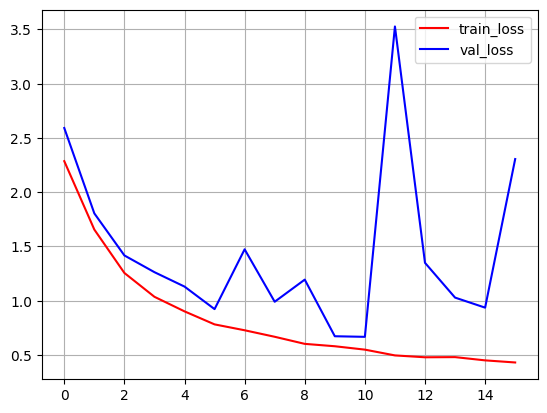

In [16]:
plt.plot(history.history['loss'], color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'val_loss')
plt.legend()
plt.grid()
plt.plot()
plt.show()

<Axes: >

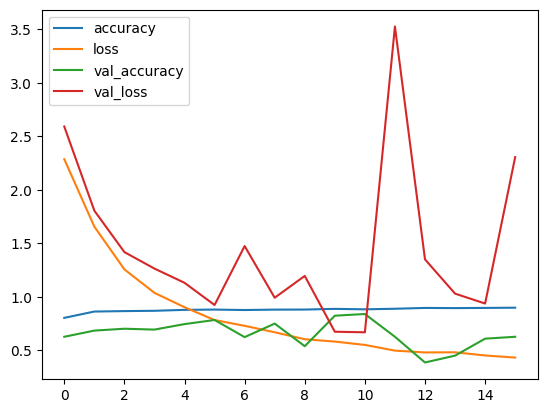

In [17]:
pd.DataFrame(history.history).plot()

In [18]:
model.save('Pneumonia_model.h5')

## <div style="text-align: left; background-color:aliceblue ; font-family: Jokerman; color: black; padding: 15px; line-height:1;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 25px;border-style: solid;border-color: dark green;">  prediction on random data  </div> 

### Prediction on NormaL Xray

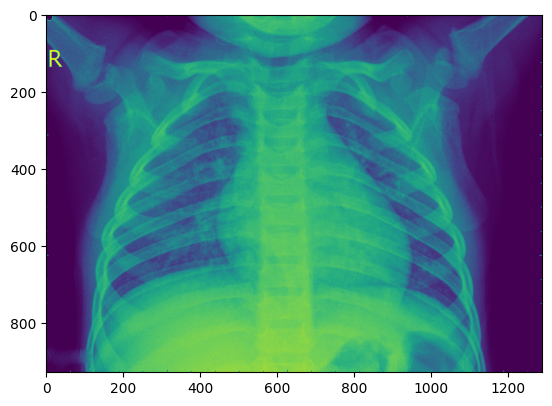

In [19]:
# Specify the path to the image file
Normal_xray_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'

# Read the image using imread
Normal_xray_image = mpimg.imread(Normal_xray_path)

# Display the image using imshow
plt.imshow(Normal_xray_image)
plt.show()


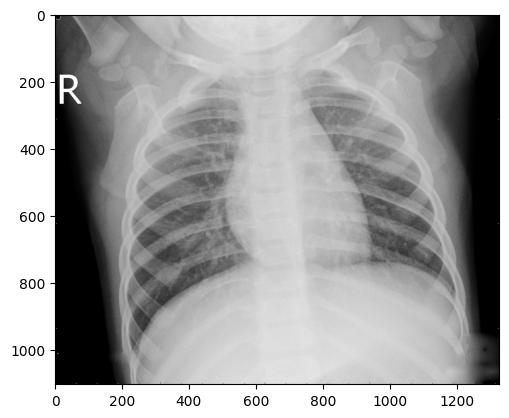

In [20]:
# Specify the path to the image file
Normal_xray_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'

# Read the image using OpenCV
Normal_xray_image = cv2.imread(Normal_xray_path)

# Convert the image to grayscale
Normal_xray_image_gray = cv2.cvtColor(Normal_xray_image, cv2.COLOR_BGR2GRAY)


# Normalize the resized image
resized_image_normalized = Normal_xray_image_gray / 255.0

# Resize the image to match the desired dimensions
resized_image = cv2.resize(resized_image_normalized, (600, 600))

# Reshape the image to match the expected input shape of the model
resized_image = resized_image.reshape(-1, 600, 600, 1)

# Convert the data type to float32
resized_image = resized_image.astype(np.float32)

# Display the resized grayscale image
plt.imshow(resized_image_normalized, cmap='gray')
plt.axis('on')
plt.show()


In [21]:
predictions = model.predict(resized_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [22]:
print((predictions>0.5).astype("int"))

[[0]]


### Prediction on Pneumonia Xray

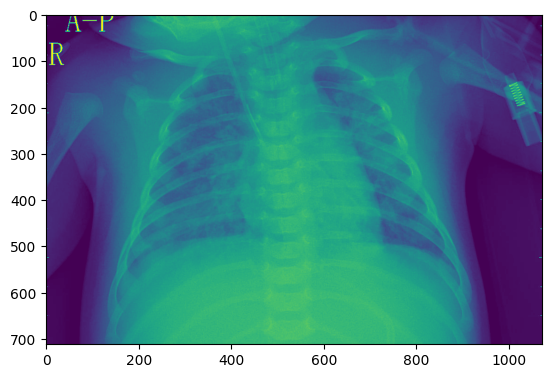

In [23]:
# Specify the path to the image file
Pneumonia_xray_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg'

# Read the image using imread
Pneumonia_xray_image = mpimg.imread(Pneumonia_xray_path)

# Display the image using imshow
plt.imshow(Pneumonia_xray_image)
plt.show()


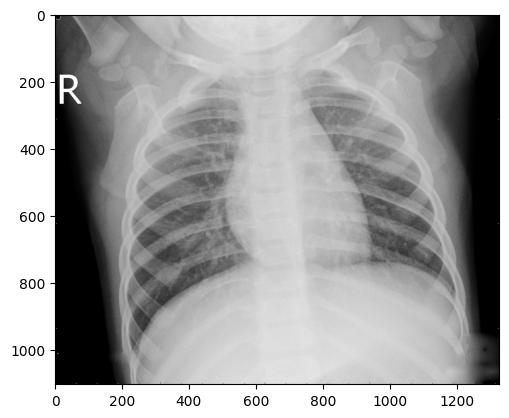

In [24]:
# Specify the path to the image file
Pneumonia_xray_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1004_bacteria_2935.jpeg'

# Read the image using OpenCV
Pneumonia_xray_image = cv2.imread(Pneumonia_xray_path)

# Convert the image to grayscale
Pneumonia_xray_image_gray = cv2.cvtColor(Pneumonia_xray_image, cv2.COLOR_BGR2GRAY)

# Normalize the resized image
Pneumonia_xray_image_normalized = Pneumonia_xray_image_gray / 255.0

# Resize the image to match the desired dimensions
resized_image = cv2.resize(Pneumonia_xray_image_normalized, (600, 600))

# Reshape the image to match the expected input shape of the model
resized_image = resized_image.reshape(-1, 600, 600, 1)

# Convert the data type to float32
resized_image = resized_image.astype(np.float32)

# Display the resized grayscale image
plt.imshow(resized_image_normalized, cmap='gray')
plt.axis('on')
plt.show()


In [25]:
predictions = model.predict(resized_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [26]:
print((predictions>0.5).astype("int"))

[[1]]
